In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [3]:
from pyspark.sql.functions import *

In [4]:
data = spark.read.csv('hack_data.csv',header=True,inferSchema =True)

In [5]:
data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [6]:
from pyspark.ml.feature import VectorAssembler

In [7]:
data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [8]:
assembler = VectorAssembler(inputCols=['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'], outputCol='features')

In [9]:
final_data = assembler.transform(data)

In [10]:
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)



In [11]:
from pyspark.ml.feature import StandardScaler

In [12]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeat')

In [13]:
final_data = scaler.fit(final_data).transform(final_data)

In [14]:
final_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)



In [15]:
from pyspark.ml.clustering import KMeans

In [16]:
kmeans = KMeans(featuresCol='scaledFeat',k=2)

In [17]:
model = kmeans.fit(final_data)

In [18]:
results = model.transform(final_data)

In [19]:
centers = model.clusterCenters()

In [20]:
print(centers)

[array([2.99991988, 2.92319035, 1.05261534, 3.20390443, 4.51321315,
       3.28474   ]), array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
       5.26676612])]


In [21]:
results.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [22]:
results.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|        prediction|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|               0.5|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|0.5007501879687625|
|    min|                    1.0|             

In [23]:
results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [24]:
results_pd = results.toPandas()

In [25]:
results_pd

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed,features,scaledFeat,prediction
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37,"[8.0, 391.09, 1.0, 2.96, 7.0, 72.37]","[0.5678510846650524, 1.3658432518957642, 1.997...",1
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08,"[20.0, 720.99, 0.0, 3.04, 9.0, 69.08]","[1.419627711662631, 2.517986463945197, 0.0, 1....",1
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58,"[31.0, 356.32, 1.0, 3.71, 8.0, 70.58]","[2.2004229530770782, 1.2444124562517545, 1.997...",1
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80,"[2.0, 228.08, 1.0, 2.48, 8.0, 70.8]","[0.1419627711662631, 0.7965469045293562, 1.997...",1
4,20.0,408.50,0,3.57,8.0,Iraq,71.28,"[20.0, 408.5, 0.0, 3.57, 8.0, 71.28]","[1.419627711662631, 1.4266459597520256, 0.0, 1...",1
...,...,...,...,...,...,...,...,...,...,...
329,39.0,761.91,1,6.99,14.0,Belarus,43.23,"[39.0, 761.91, 1.0, 6.99, 14.0, 43.23]","[2.7682740377421307, 2.660895528016318, 1.9975...",0
330,43.0,983.48,0,8.60,13.0,British Indian Ocean Territory (Chagos Archipe...,43.21,"[43.0, 983.48, 0.0, 8.6, 13.0, 43.21]","[3.0521995800746566, 3.4347068996252683, 0.0, ...",0
331,39.0,690.22,1,6.80,13.0,Guinea-Bissau,42.75,"[39.0, 690.22, 1.0, 6.8, 13.0, 42.75]","[2.7682740377421307, 2.4105252737822354, 1.997...",0
332,36.0,1060.69,1,6.26,14.0,Canada,43.86,"[36.0, 1060.69, 1.0, 6.26, 14.0, 43.86]","[2.555329880992736, 3.704355209423197, 1.99757...",0


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

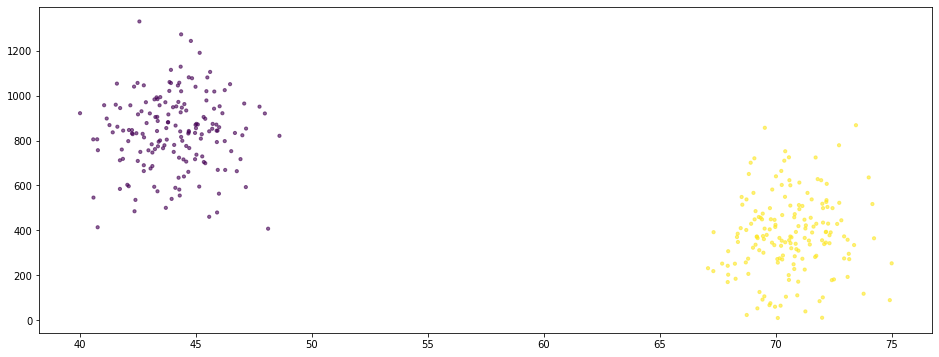

In [27]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['WPM_Typing_Speed'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

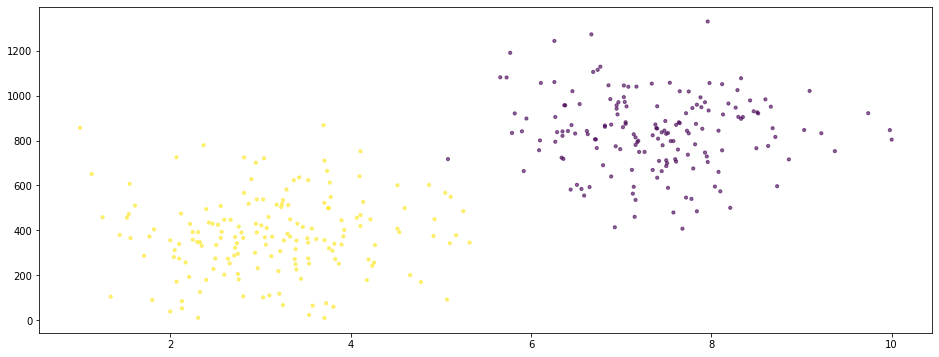

In [28]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

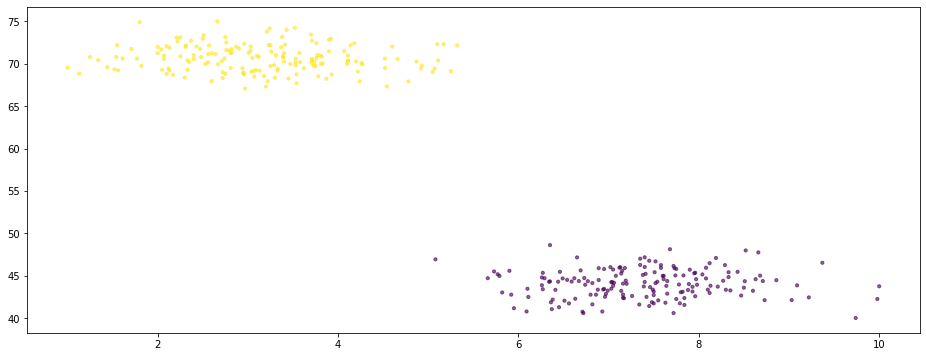

In [29]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['WPM_Typing_Speed'], c= results_pd['prediction'], alpha = 0.6, s=10)

In [30]:
kmeans = KMeans(featuresCol='scaledFeat',k=3)
model = kmeans.fit(final_data)
results = model.transform(final_data)
centers = model.clusterCenters()
results.printSchema()
results.groupBy('prediction').count().show()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   88|
|         2|   79|
|         0|  167|
+----------+-----+



In [31]:
results_pd = results.toPandas()

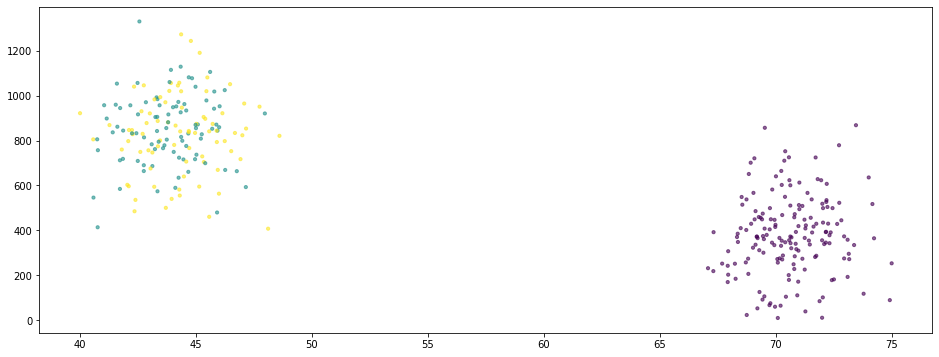

In [32]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['WPM_Typing_Speed'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

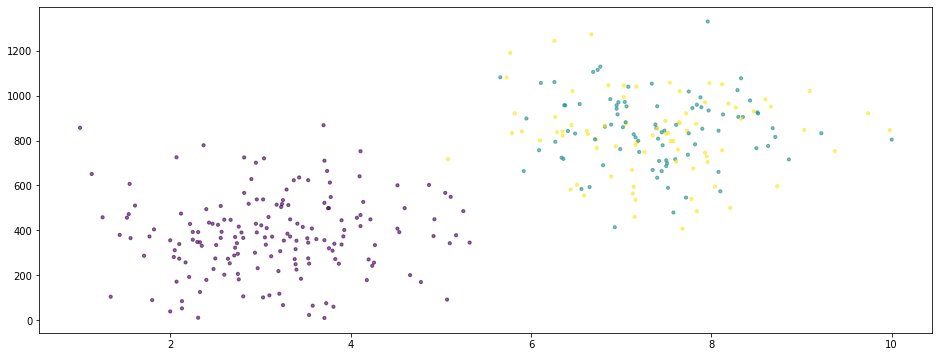

In [33]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

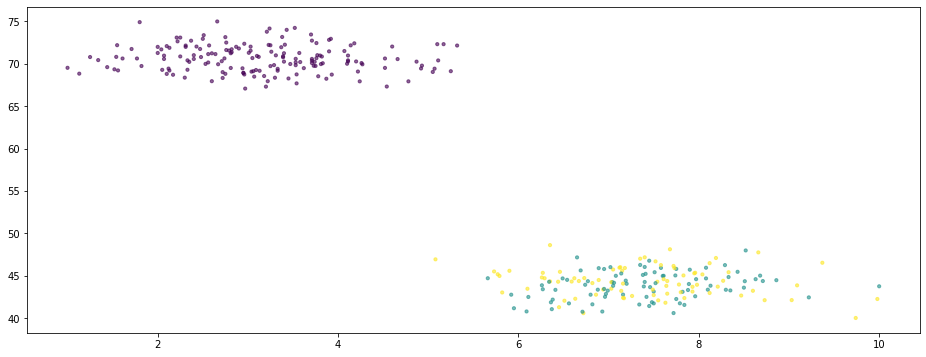

In [34]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['WPM_Typing_Speed'], c= results_pd['prediction'], alpha = 0.6, s=10)

In [35]:
kmeans = KMeans(featuresCol='scaledFeat',k=4)
model = kmeans.fit(final_data)
results = model.transform(final_data)
centers = model.clusterCenters()
results.printSchema()
results.groupBy('prediction').count().show()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   88|
|         3|   48|
|         2|   31|
|         0|  167|
+----------+-----+



In [36]:
results_pd = results.toPandas()

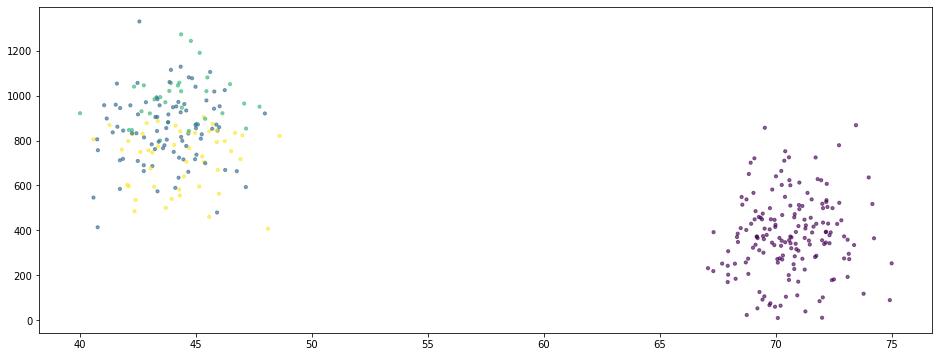

In [37]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['WPM_Typing_Speed'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

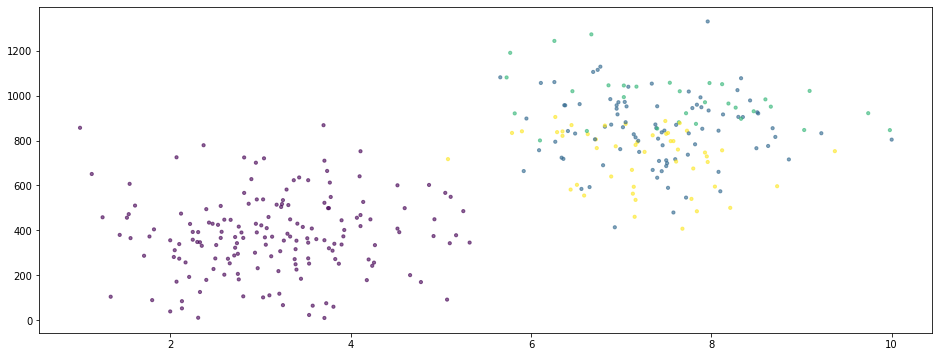

In [38]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

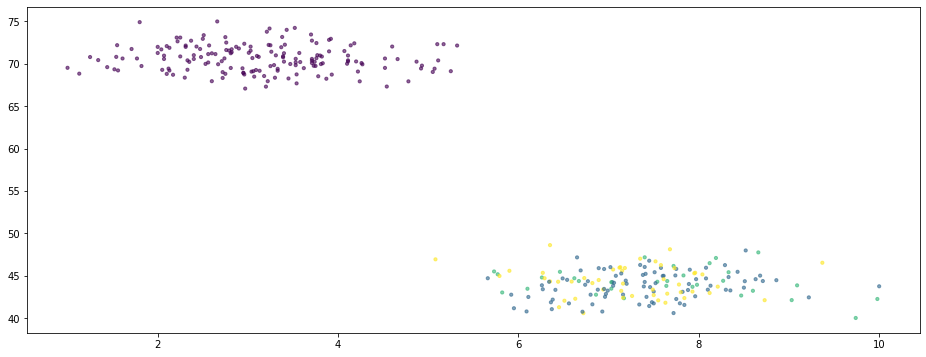

In [39]:
plt.figure(figsize = (16, 6))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['WPM_Typing_Speed'], c= results_pd['prediction'], alpha = 0.6, s=10)

In [40]:
kmeans = KMeans(featuresCol='scaledFeat',k=8)
model = kmeans.fit(final_data)
results = model.transform(final_data)
centers = model.clusterCenters()
results.printSchema()
results.groupBy('prediction').count().show()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)
 |-- prediction: integer (nullable = false)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         6|   38|
|         3|   58|
|         5|   32|
|         4|   34|
|         7|   47|
|         2|   26|
|         0|   49|
+----------+-----+



In [41]:
results_pd = results.toPandas()

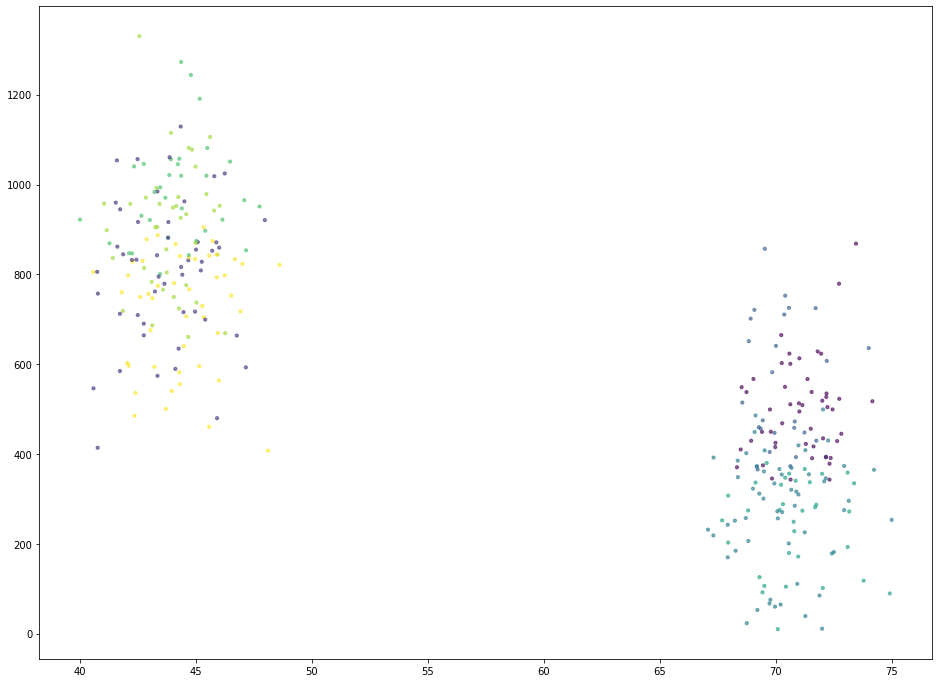

In [42]:
plt.figure(figsize = (16, 12))
plt.scatter(results_pd['WPM_Typing_Speed'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

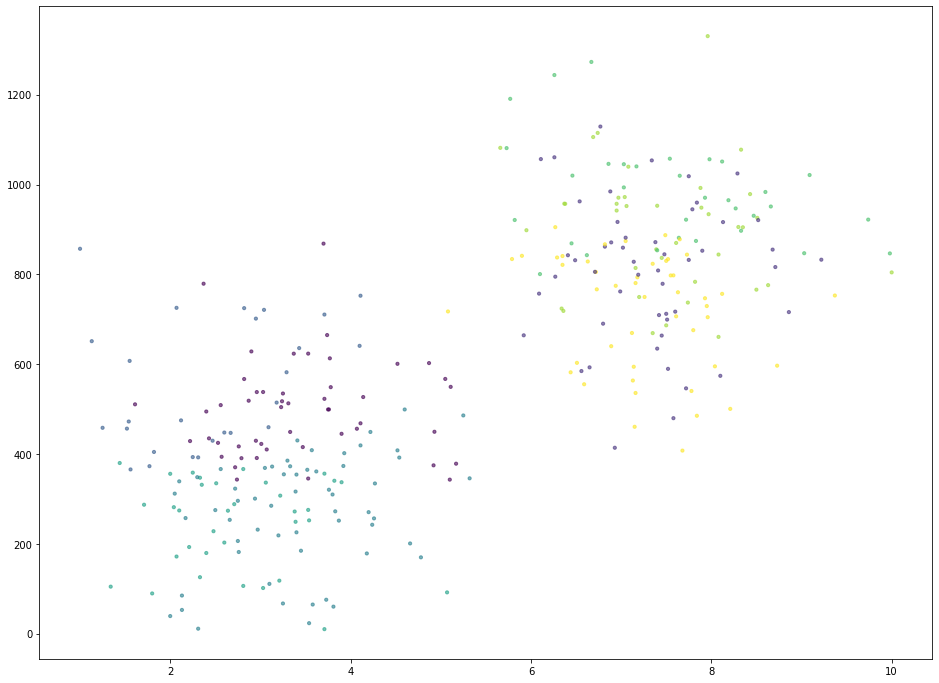

In [43]:
plt.figure(figsize = (16, 12))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['Bytes Transferred'], c= results_pd['prediction'], alpha = 0.6, s=10)

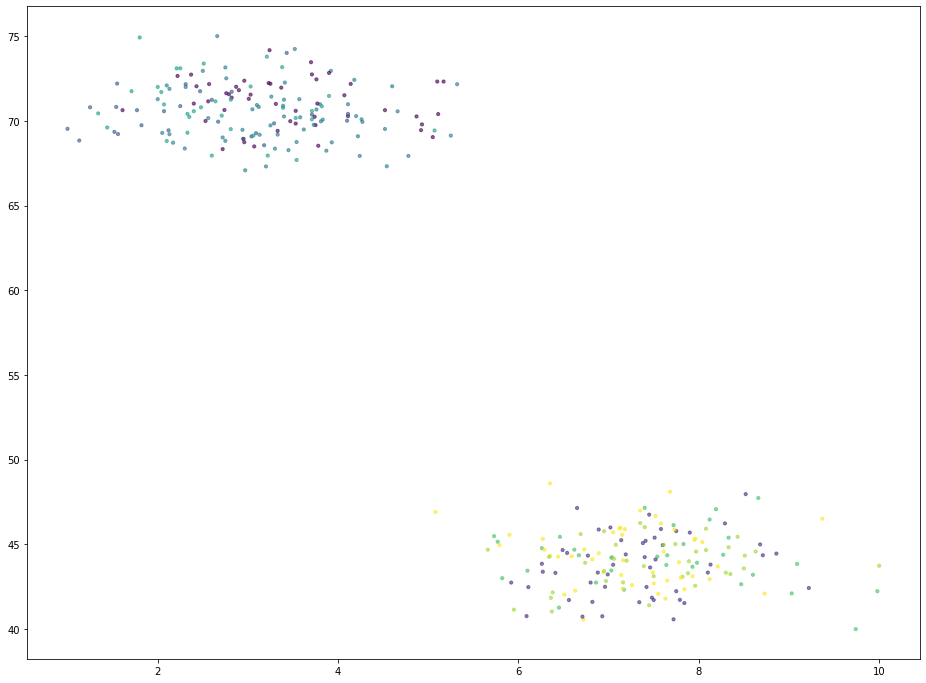

In [44]:
plt.figure(figsize = (16, 12))
plt.scatter(results_pd['Servers_Corrupted'], results_pd['WPM_Typing_Speed'], c= results_pd['prediction'], alpha = 0.6, s=10)